# Quick Start

**A tutorial on Renormalized Mutual Information**

We describe in detail the implementation of RMI estimation in the very simple case of a Gaussian distribution.
Of course, in this case the optimal feature is given by the Principal Component Analysis

In [1]:
import numpy as np

# parameters of the Gaussian distribution
mu = [0,0]
sigma = [[1, 0.5],[0.5,2]]

# extract the samples
N_samples = 100000
samples = np.random.multivariate_normal(mu, sigma, N_samples )

Visualize the distribution with a 2D histogram

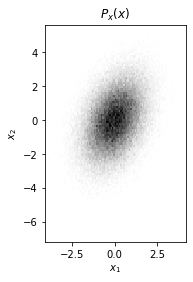

In [2]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist2d(*samples.T, bins=100, cmap=plt.cm.binary)
plt.gca().set_aspect("equal")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("$P_x(x)$")
plt.show()

## Estimate Renormalized Mutual Information of a feature

Now we would like to find a one-dimensional function $f(x_1,x_2)$ to describe this 2d distribution.

### Simplest feature
For example, we could consider ignoring one of the variables:

In [3]:
def f(x):
    # feature
    # shape [N_samples, N_features=1]
    return x[:,0][...,None]

def grad_f(x):
    # gradient
    # shape [N_samples, N_features=1, N_x=2]
    grad_f = np.zeros([len(x),1,2])
    grad_f[...,0] = 1
    return grad_f

def feat_and_grad(x):
    return f(x), grad_f(x)

Let's plot it on top of the distribution

In [4]:
# Range of the plot
xmin = -4
xmax = 4
# Number of points in the grid
N = 100

# We evaluate the feature on a grid
x_linspace = np.linspace(xmin, xmax, N)
x1_grid, x2_grid = np.meshgrid(x_linspace, x_linspace, indexing='ij')
x_points = np.array([x1_grid.flatten(), x2_grid.flatten()]).T

feature = f(x_points)
gradient = grad_f(x_points)

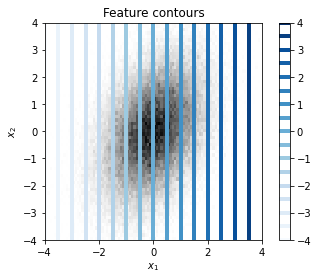

In [5]:
plt.figure()
plt.title("Feature contours")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.gca().set_aspect('equal')
# Draw the input distribution on the background
plt.hist2d(*samples.T, bins=100, cmap=plt.cm.binary)

# Draw the contour lines of the extracted feature
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.contour(x1_grid, x2_grid, feature.reshape([N,N]),15, 
           linewidths=4, cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

$f(x)=x_1$ is clearly a linear function that ignores $x_2$ and increases in the $x_1$ direction

**How much information does it give us on $x$?**
If we used common mutual information, it would be $\infty$, because $f$ is a deterministic function, and $H(y|x) = -\log \delta(0)$.

Let's estimate the renormalized mutual information

In [6]:
import rmi.estimation as inf

samples = np.random.multivariate_normal(mu, sigma, N_samples )

feature = f(samples)
gradient = grad_f(samples)
RMI = inf.RenormalizedMutualInformation(feature, gradient)
print("Renormalized Mutual Information (x,f(x)): %2.2f" % RMI)

Renormalized Mutual Information (x,f(x)): 1.42


Please note that we perform the plot by calculating the feature on a uniform grid. But, to estimate RMI, the feature should be calculated on x **sampled** from the $x$ distribution.

In particular, we have

In [7]:
p_y, delta_y = inf.produce_P(feature)
entropy = inf.Entropy(p_y, delta_y)

fterm = inf.RegTerm(gradient)

print("Entropy\t  %2.2f" % entropy)
print("Fterm\t %2.2f" % fterm)

print("Renormalized Mutual Information (x,f(x)): %2.2f" % 
      (entropy + fterm))

Entropy	  1.42
Fterm	 -0.00
Renormalized Mutual Information (x,f(x)): 1.42


Renormalized Mutual Information is the sum of the two terms
- Entropy
- RegTerm

### Reparametrization invariance

Do we gain information if we increase the variance of the feature?

For example, let's rescale our feature. Clearly the information on $x$ should remain the same

In [8]:
scale_factor = 4
feature *= scale_factor
gradient *= scale_factor

RMI = inf.RenormalizedMutualInformation(feature, gradient)
print("Renormalized Mutual Information (x,f(x)): %2.2f" % RMI)

p_y, delta_y = inf.produce_P(feature)
entropy = inf.Entropy(p_y, delta_y)
fterm = inf.RegTerm(gradient)

print("Entropy\t  %2.2f" % entropy)
print("Fterm\t %2.2f" % fterm)

Renormalized Mutual Information (x,f(x)): 1.42
Entropy	  2.80
Fterm	 -1.39


Let's try even a non-linear transformation. As long as it is invertible, we will get the same RMI

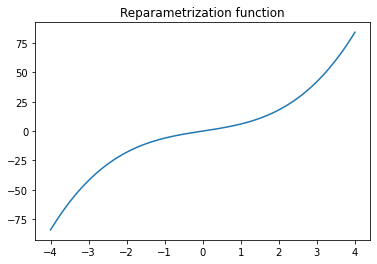

In [9]:
# For example
y_lin = np.linspace(-4,4,100)
f_lin = y_lin**3 + 5*y_lin
plt.figure()
plt.title("Reparametrization function")
plt.plot(y_lin, f_lin)
plt.show()

In [10]:
feature_new = feature**3 + 5*feature
gradient_new = 3*feature[...,None]**2*gradient +5*gradient# chain rule...

RMI = inf.RenormalizedMutualInformation(feature_new, gradient_new, 2000)
print("Renormalized Mutual Information (x,f(x)): %2.2f" % RMI)

p_y, delta_y = inf.produce_P(feature_new)
entropy = inf.Entropy(p_y, delta_y)
fterm = inf.RegTerm(gradient_new)

print("Entropy\t  %2.2f" % entropy)
print("Fterm\t %2.2f" % fterm)


Renormalized Mutual Information (x,f(x)): 1.42
Entropy	  6.24
Fterm	 -4.70


In this case, we have to increase the number of bins 
to calculate the Entropy with reasonable accuracy.
The reason is that the feature now spans a quite larger range but changes very rapidly in the few bins around zero (but we use a uniform binning when estimating the entropy).

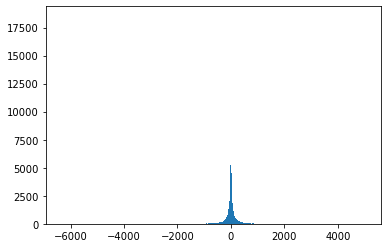

In [11]:
plt.hist(feature_new,1000)
plt.show()

And if we instead appliead a **non-invertible** transformation? The consequence is clear: we will **lose information**.
Consider for example:

In [12]:
feature_new = feature**2
gradient_new = 2*feature[...,None]*gradient # chain rule...

RMI_2 = inf.RenormalizedMutualInformation(feature_new, gradient_new, 2000)
print("Renormalized Mutual Information (x,f(x)): %2.2f" % RMI_2)

p_y, delta_y = inf.produce_P(feature_new)
entropy = inf.Entropy(p_y, delta_y)
fterm = inf.RegTerm(gradient_new)

print("Entropy\t  %2.2f" % entropy)
print("Fterm\t %2.2f" % fterm)


Renormalized Mutual Information (x,f(x)): 0.74
Entropy	  3.64
Fterm	 -2.83


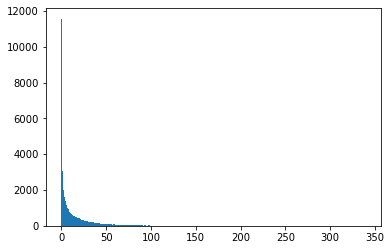

In [13]:
plt.hist(feature_new,1000)
plt.show()

The careful observer will be able to guess how much information we have lost in this case: 
our feature is centered in zero and we squared it. We lose the sign, and on average the half of the samples have one sign and the half the other sign. One bit of information is lost. The difference is $\log 2$!

In [14]:
deltaRMI = RMI - RMI_2
print("delta RMI %2.3f" %deltaRMI)
print("log 2 = %2.3f" % np.log(2))

delta RMI 0.672
log 2 = 0.693


### Another feature

Let's take another linear feature, for example, this time in the other direction 

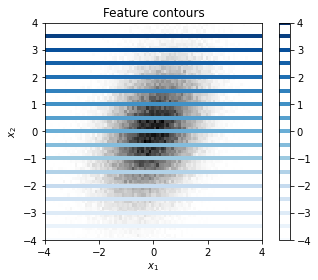

Renormalized Mutual Information (x,f(x)): 1.77


In [15]:
def f(x):
    # feature
    # shape [N_samples, N_features=1]
    return x[:,1][...,None]

def grad_f(x):
    # gradient
    # shape [N_samples, N_features=1, N_x=2]
    grad_f = np.zeros([len(x),1,2])
    grad_f[...,1] = 1
    return grad_f

def feat_and_grad(x):
    return f(x), grad_f(x)

feature = f(x_points)
gradient = grad_f(x_points)

plt.figure()
plt.title("Feature contours")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.gca().set_aspect('equal')
# Draw the input distribution on the background
samples = np.random.multivariate_normal(mu, sigma, N_samples )
plt.hist2d(*samples.T, bins=100, cmap=plt.cm.binary)

# Draw the contour lines of the extracted feature
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.contour(x1_grid, x2_grid, feature.reshape([N,N]),15, 
           linewidths=4, cmap=plt.cm.Blues)
plt.colorbar()
plt.show()


feature = f(samples)
gradient = grad_f(samples)
RMI = inf.RenormalizedMutualInformation(feature, gradient)
print("Renormalized Mutual Information (x,f(x)): %2.2f" % RMI)

This feature seems to better describe our input. This is reasonable: it lies closer to the direction of larger fluctuation of the distribution.

What is the best linear feature that we can take?

In [16]:
# Let's define a linear feature
def linear(x, th):
    """ linear increasing in the direction given by angle th.

    Args:
        x (array_like): [N_samples, 2] array of samples
        th (float): direction of the feature in which it increases

    Returns:
        feature (array_like): [N_samples, 1] feature
        grad_feature (array_like): [N_samples, 1, N_x] gradient of the feature
    """

    Feature = x[:, 0]*np.cos(th) + x[:, 1]*np.sin(th)
    Grad1 = np.full(np.shape(x)[0], np.cos(th))
    Grad2 = np.full(np.shape(x)[0], np.sin(th))
    return Feature, np.array([Grad1, Grad2]).T

samples = np.random.multivariate_normal(mu, sigma, N_samples )

th_lin = np.linspace(0,np.pi, 30)
rmis = []
for th in th_lin:
    feature, grad = linear(samples, th)
    rmi = inf.RenormalizedMutualInformation(feature,grad)
    rmis.append([th,rmi])
rmis = np.array(rmis)

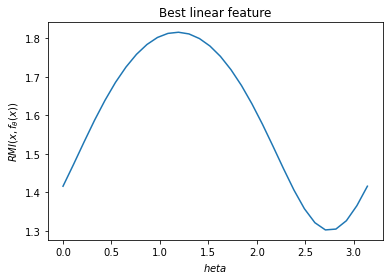

In [17]:
plt.figure()
plt.title("Best linear feature")
plt.xlabel("$\theta$")
plt.ylabel(r"$RMI(x,f_\theta(x))$")
plt.plot(rmis[:,0], rmis[:,1])
plt.show()

best_theta = th_lin[np.argmax(rmis[:,1])]

Let's plot the feature with the parameter that gives the largest Renormalized Mutual Information

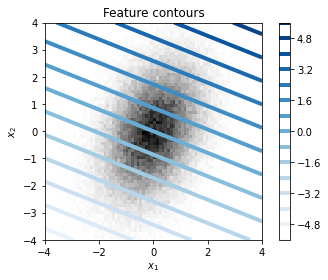

Renormalized Mutual Information (x,f(x)): 1.81


In [18]:

feature, gradient  = linear(x_points,best_theta)

plt.figure()
plt.title("Feature contours")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.gca().set_aspect('equal')
# Draw the input distribution on the background
samples = np.random.multivariate_normal(mu, sigma, N_samples )
plt.hist2d(*samples.T, bins=100, cmap=plt.cm.binary)

# Draw the contour lines of the extracted feature
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.contour(x1_grid, x2_grid, feature.reshape([N,N]),15, 
           linewidths=4, cmap=plt.cm.Blues)
plt.colorbar()
plt.show()


feature, gradient = linear(samples,best_theta)
RMI = inf.RenormalizedMutualInformation(feature, gradient)
print("Renormalized Mutual Information (x,f(x)): %2.2f" % RMI)

This is the same feature that we would get if we considered the first Principal Component of PCA. This is the only case in which this is possible: PCA can only extract linear features, and in particular, since it only takes into account the covariance matrix of the distribution, it can provide the best feature only for a Gaussian (which is identified by its mean and covariance matrix)

In [19]:
import rmi.pca
samples = np.random.multivariate_normal(mu, sigma, N_samples )
g_pca = rmi.pca.pca(samples,1)
eigenv = g_pca.w[0]
angle_pca = np.arctan(eigenv[1]/eigenv[0])

feature, gradient = linear(samples,angle_pca)
RMI = inf.RenormalizedMutualInformation(feature, gradient)
print("Renormalized Mutual Information (x,f(x)): %2.2f" % RMI)

Renormalized Mutual Information (x,f(x)): 1.81


In [20]:
print("best found angle %2.2f" %best_theta)
print("pca direction %2.2f" %angle_pca)

best found angle 1.19
pca direction 1.18


We recall that in this very special case, and as long as the proposed feature is only rotated (without changing the scale), the simple maximization of the Feature Entropy would have given the same result.

Again, this only holds for linear features, and in particular for those whose gradient vector is not affected by a change of parameters).

As soon as we use a non-linear feature, just looking at the entropy of the feature is not enough anymore - entropy is not reparametrization invariant.

Also, given an arbitrary deterministic feature function, RMI is the only quantity that allows to estimate it's dependence with its arguments

## Feature Optimization

Let's try now to optimize a neural network to extract a feature. In this case, as we already discussed, we will still get a linear feature

In [21]:
import rmi.neuralnets as nn

# Define the layout of the neural network
# The cost function is implicit when choosing the model RMIOptimizer
rmi_optimizer = nn.RMIOptimizer(
    layers=[
        nn.K.layers.Dense(30, activation="relu",input_shape=(2,)),
        nn.K.layers.Dense(1)
])

# Compile the network === choose the optimizer to use during the training
rmi_optimizer.compile(optimizer=nn.tf.optimizers.Adam(1e-3))

# Print the table with the structure of the network
rmi_optimizer.summary()

# Define an objects that handles the training
rmi_net = nn.Net(rmi_optimizer)

Model: "rmi_optimizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                90        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Perform the training of the neural network
batchsize = 1000
N_train = 5000
def get_batch():
    return np.random.multivariate_normal(mu, sigma, batchsize)
rmi_net.fit_generator(get_batch, N_train)

  0%|          | 0/5000 [00:00<?, ?it/s]

Starting the training of the model...
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


100%|██████████| 5000/5000 [00:17<00:00, 283.81it/s]

No saving path specified. Network won't be saved to disk.


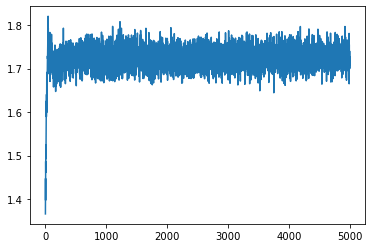

In [23]:
# Plot the training history (value of RMI)
# The large fluctuations can be reduced by increasing the batchsize
rmi_net.plot_history()

Calculate the feature on the input points: just apply the object `rmi_net`!

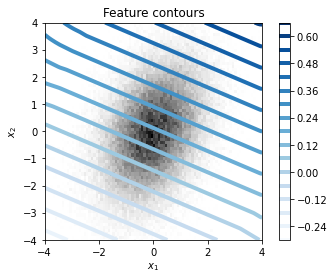

In [24]:
feature  = rmi_net(x_points)

plt.figure()
plt.title("Feature contours")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.gca().set_aspect('equal')
# Draw the input distribution on the background
samples = np.random.multivariate_normal(mu, sigma, N_samples )
plt.hist2d(*samples.T, bins=100, cmap=plt.cm.binary)

# Draw the contour lines of the extracted feature
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.contour(x1_grid, x2_grid, feature.reshape([N,N]),15, 
           linewidths=4, cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

To calculate also the gradient of the feature, one can use the function `get_feature_and_grad`

In [25]:
feature, gradient = rmi_net.get_feature_and_grad(samples)
RMI = inf.RenormalizedMutualInformation(feature, gradient)
print("Renormalized Mutual Information (x,f(x)): %2.2f" % RMI)

Renormalized Mutual Information (x,f(x)): 1.81


## Tradeoff between simplicity and compression

When optimizing renormalized mutual information to obtain a **meaningful feature** (in the sense of representation learning), one should avoid to employ too powerful networks.

A good feature should set a convenient tradeoff between its **"simplicity"** (i.e. number of parameters, or how "smooth" the feature is) and its **information content** (i.e. how much the input space is compressed in a smaller dimension). 

In other words, useful representations should be "well-behaved", even at the price of reducing their renormalized mutual information. We can show this idea in a straight forward example


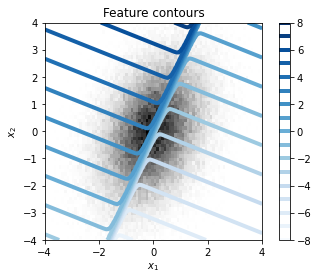

Renormalized Mutual Information (x,f(x)): 2.04
Entropy	  2.45
Fterm	 -0.41


In [26]:
# Let's define a linear feature
def cheating_feature(x):
    Feature = x[:, 0]*np.cos(best_theta) + x[:, 1]*np.sin(best_theta) 
    
    step_size = 3
    step_width = 1/12
    step_argument = x[:, 0]*np.cos(best_theta+np.pi/2) + x[:, 1]*np.sin(best_theta+np.pi/2)
    Feature +=step_size*np.tanh(step_argument/step_width)
    
    Grad1 = np.full(x.shape[0], np.cos(best_theta))
    Grad2 = np.full(x.shape[0], np.sin(best_theta))
    
    Grad1 += step_size/step_width*np.cos(best_theta+np.pi/2)/np.cosh(step_argument/step_width)**2
    Grad2 += step_size/step_width*np.sin(best_theta+np.pi/2)/np.cosh(step_argument/step_width)**2
    return Feature, np.array([Grad1, Grad2]).T

samples = np.random.multivariate_normal(mu, sigma, N_samples )

feature, gradient = cheating_feature(x_points)

plt.figure()
plt.title("Feature contours")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.gca().set_aspect('equal')
# Draw the input distribution on the background
samples = np.random.multivariate_normal(mu, sigma, N_samples )
plt.hist2d(*samples.T, bins=100, cmap=plt.cm.binary)

# Draw the contour lines of the extracted feature
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.contour(x1_grid, x2_grid, feature.reshape([N,N]),15, 
           linewidths=4, cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

feature, gradient = cheating_feature(samples)
RMI = inf.RenormalizedMutualInformation(feature, gradient)
print("Renormalized Mutual Information (x,f(x)): %2.2f" % RMI)

p_y, delta_y = inf.produce_P(feature)
entropy = inf.Entropy(p_y, delta_y)
fterm = inf.RegTerm(gradient)

print("Entropy\t  %2.2f" % entropy)
print("Fterm\t %2.2f" % fterm)


This feature has a larger mutual information than the linear one. It is still increasing in the direction of largest variance of $x$.

However, it contains a _jump_ in the orthogonal direction. This jump allows to encode a "bit" of additional information (about the orthogonal coordinate), allowing to unambiguously distinguish whether $x$ was extracted on the left or right side of the Gaussian.

In principle, one can add an arbitrary number of jumps until the missing coordinate can be identified with arbitrary precision. This feature would have an arbitrary high renormalized mutual information (as it should be, since it contains more information on $x$). However, such a non-smooth feature is definitely not useful for feature extraction!

One can avoid these extremely compressed representations by encouraging simpler features (like smooth, or a neural network with a limited number of layers for example).

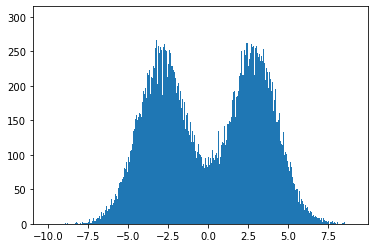

In [27]:
# Histogram of the feature
# The continuous value of x encodes one coordinate, 
# the two peaks of the distribution provide additional information 
# on the second coordinate!
plt.hist(feature,1000)
plt.show()

## Conclusions

This technique can be applied to 
- estimate the information that a deterministic feature $f(x)$ carries about a (higher-dimensional) $x$
    - in other words, to estimate how useful is a given "macroscopic" quantity to describe a system?
- extract non-linear representations in an unsupervised way, by optimizinng Renormalized Mutual Information. 

For more examples: 
- see the notebooks with the spiral-shaped distribution for an example with a non-Gaussian input distribution
- see the Wave Packet and Liquid Drop notebooks for proof-of-concept applications in physics (or in general for higher-dimensional input spaces and extraction of a two-dimensional feature)

At the moment, only one-dimensional or two-dimensional features can be extracted with the neural network class. This is due to the implementation of the Entropy estimation, which currently is based on a histogram - which is not efficient in larger dimensions. An alternative (differentiable) way to estimate the Entropy will allow to extend this technique to also extract features with more than 2 dimensions.